In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.9":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.9":
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.21.1", 'matplotlib': "3.4.2",'sklearn': "0.24.2", 
                'pandas': "1.3.1",'xgboost': "1.3.3", 'shap': "0.39.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.9.7 | packaged by conda-forge | (default, Sep  2 2021, 17:55:20) [MSC v.1916 64 bit (AMD64)]

[ OK ] numpy version 1.21.1 is installed.
[ OK ] matplotlib version 3.4.2 is installed.
[ OK ] sklearn version 0.24.2 is installed.
[ OK ] pandas version 1.3.1 is installed.
[ OK ] xgboost version 1.3.3 is installed.
[ OK ] shap version 0.39.0 is installed.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pylab as plt
%pylab inline
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from  sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy


In [3]:
fontsize=14
rcParams['font.size']=fontsize
rcParams['font.family']='sans-serif'
rcParams['axes.labelsize']=fontsize
rcParams['axes.titlesize']=fontsize
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=fontsize
rcParams['legend.fontsize']=fontsize
rcParams['figure.figsize']=(10,7.5)
rcParams['axes.grid']=True

In [4]:
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('data/train_V2.csv')
df.sample(10)

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.isnull().sum()

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.shape

In [ ]:
match_df = df.groupby('matchId').count()['Id']

In [ ]:
fig = plt.figure()
plt.violinplot(match_df)
plt.ylabel('number of players')
plt.xlabel('match')
plt.title('Number of Players in Each Match')
plt.show()
fig.savefig('figures/Number of Players in Each Match.jpg', dpi = 300)

In [ ]:
fig,ax = plt.subplots(figsize=(16,12))
ax = sns.heatmap(df.corr(), annot=True)
fig.savefig('figures/Correlation.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
df['winPlacePerc'].plot.hist(bins=100)
plt.xlabel('win place percentage')
plt.ylabel('count')
plt.title('Distribution of Win Place')
plt.show()
fig.savefig('figures/Distribution of Win Place.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
df.plot.scatter('killPlace','winPlacePerc',s=1,alpha=0.1)
plt.ylabel('win place percentage')
plt.xlabel('kill place')
plt.title('Distribution of Win Place vs. Kill Place')
plt.show()
fig.savefig('figures/Distribution of Win Place vs. Kill Place.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
df['walkDistance'].plot.hist(bins=50, log=True)
plt.xlabel('walk distance')
plt.ylabel('count')
plt.title('Distribution of Walk Distance')
plt.show()
fig.savefig('figures/Distribution of Walk Distance.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
df['kills'].plot.hist(bins=df['kills'].nunique(), log=True)
plt.xlabel('kills')
plt.ylabel('count')
plt.title('Distribution of Kills')
plt.show()
fig.savefig('figures/Distribution of Kills.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
df[['winPlacePerc','matchType']].boxplot(by='matchType',figsize=(22,16.5))
plt.ylabel('win place percentage')
plt.xlabel('match type')
plt.title('Distribution of Win Place')
plt.show()
fig.savefig('figures/Distribution of Win Place by Match Type.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
pd.value_counts(df['matchType'],normalize=True).plot.bar()
plt.ylabel('fraction')
plt.xlabel('match type')
plt.title('Distribution of Match Type')
plt.show()
fig.savefig('figures/Distribution of Match Type.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
pd.plotting.scatter_matrix(df[['assists', 'boosts', 'killPlace', 'kills', 'winPlacePerc']], marker='o', s=1, alpha=0.1)
plt.show()
fig.savefig('figures/Scatter Matrix.jpg', dpi = 300)

In [ ]:
n = len(pd.unique(df['Id']))
n

In [ ]:
column_list = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 
               'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace', 'revives', 'rideDistance', 
               'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints', 
               'winPlacePerc']

In [ ]:
ndf = df[column_list]
ndf.sample(10)

In [ ]:
ndf.shape

In [ ]:
sdf = ndf.sample(round(0.01*len(ndf)), random_state=11)
sdf.to_csv('data/sample.csv')

In [5]:
sdf = pd.read_csv('data/sample.csv')
sdf.head()

,Unnamed: 0,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,2069048,0,0,57.33,0,0,0,82,0,0,0,0.00,1382,squad,27,0,0.0,0,0.0,0,0,199.2,2,0,0.1538
1,25967,3,5,217.10,1,0,2,22,1231,1,1,141.80,2091,squad,26,0,2405.0,0,0.0,0,1,3711.0,5,1530,0.9200
2,2896533,0,0,242.70,0,0,0,63,0,0,0,0.00,1361,squad-fpp,28,0,0.0,0,0.0,0,0,593.8,2,0,0.3704
3,3314281,0,0,100.00,1,0,0,31,0,1,1,13.73,1387,duo-fpp,48,0,0.0,0,11.3,0,0,1150.0,3,0,0.7234
4,2707511,0,0,63.21,0,0,0,81,0,0,0,0.00,1800,duo-fpp,49,0,0.0,0,0.0,0,0,94.5,2,0,0.1667


In [6]:
nsdf = sdf.loc[:, sdf.columns != 'Unnamed: 0']
nsdf.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,57.33,0,0,0,82,0,0,0,0.00,1382,squad,27,0,0.0,0,0.0,0,0,199.2,2,0,0.1538
1,3,5,217.10,1,0,2,22,1231,1,1,141.80,2091,squad,26,0,2405.0,0,0.0,0,1,3711.0,5,1530,0.9200
2,0,0,242.70,0,0,0,63,0,0,0,0.00,1361,squad-fpp,28,0,0.0,0,0.0,0,0,593.8,2,0,0.3704
3,0,0,100.00,1,0,0,31,0,1,1,13.73,1387,duo-fpp,48,0,0.0,0,11.3,0,0,1150.0,3,0,0.7234
4,0,0,63.21,0,0,0,81,0,0,0,0.00,1800,duo-fpp,49,0,0.0,0,0.0,0,0,94.5,2,0,0.1667


In [7]:
len(nsdf)

44470

In [8]:
X = nsdf.loc[:, nsdf.columns != 'winPlacePerc']
y = nsdf['winPlacePerc']

onehot_ftrs = ['matchType']
minmax_ftrs = ['killPlace', 'maxPlace']
std_ftrs = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPoints', 'kills', 'killStreaks', 
            'longestKill', 'matchDuration', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 
            'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

prep = Pipeline(steps=[('preprocessor', preprocessor)])

In [9]:
param_grid_dt = {'splitter': ['best','random'], 'max_depth': range(7, 12), 'max_features': ['auto','log2','sqrt']}

In [10]:
nr_states = 6
test_scores = np.zeros(nr_states)
final_models = []

for i in range(nr_states):
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=11*i)
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=11*i)
    
    X_train_prep = prep.fit_transform(X_train)
    X_val_prep = prep.transform(X_val)
    X_test_prep = prep.transform(X_test)
    
    train_score = np.zeros(len(ParameterGrid(param_grid_dt)))
    val_score = np.zeros(len(ParameterGrid(param_grid_dt)))
    models = []
    
    for p in range(len(ParameterGrid(param_grid_dt))):
        params = ParameterGrid(param_grid_dt)[p]
        clf = DecisionTreeRegressor(**params,random_state=11*i)
        clf.fit(X_train_prep, y_train)
        models.append(clf)
        
        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        y_train_pred = np.where(y_train_pred > 1.0, 1.0, y_train_pred)
        y_train_pred = np.where(y_train_pred < 0.0, 0.0, y_train_pred)
        y_val_pred = np.where(y_val_pred > 1.0, 1.0, y_val_pred)
        y_val_pred = np.where(y_val_pred < 0.0, 0.0, y_val_pred)
        
        train_score[p] = mean_absolute_error(y_train, y_train_pred)
        val_score[p] = mean_absolute_error(y_val, y_val_pred)
    
    print('best model parameters:',ParameterGrid(param_grid_dt)[np.argmin(val_score)])
    print('corresponding validation score:',np.min(val_score))
    final_models.append(models[np.argmin(val_score)])
    y_test_pred = final_models[-1].predict(X_test_prep)
    y_test_pred = np.where(y_test_pred > 1.0, 1.0, y_test_pred)
    y_test_pred = np.where(y_test_pred < 0.0, 0.0, y_test_pred)
    test_scores[i] = mean_absolute_error(y_test, y_test_pred)
    print('test score:',test_scores[i])

best model parameters: {'splitter': 'best', 'max_features': 'auto', 'max_depth': 10}
corresponding validation score: 0.07664530882648066
test score: 0.07560962129897625
best model parameters: {'splitter': 'best', 'max_features': 'auto', 'max_depth': 10}
corresponding validation score: 0.07564348260603183
test score: 0.07487148906129344
best model parameters: {'splitter': 'best', 'max_features': 'auto', 'max_depth': 10}
corresponding validation score: 0.0752087768492371
test score: 0.07603132255514149
best model parameters: {'splitter': 'best', 'max_features': 'auto', 'max_depth': 9}
corresponding validation score: 0.07749522886994448
test score: 0.07728403085435401
best model parameters: {'splitter': 'best', 'max_features': 'auto', 'max_depth': 10}
corresponding validation score: 0.07616916101991399
test score: 0.07618618098909186
best model parameters: {'splitter': 'best', 'max_features': 'auto', 'max_depth': 9}
corresponding validation score: 0.07727899481727733
test score: 0.0780114

In [11]:
dt_models = final_models
dt_models

[DecisionTreeRegressor(max_depth=10, max_features='auto', random_state=0),
 DecisionTreeRegressor(max_depth=10, max_features='auto', random_state=11),
 DecisionTreeRegressor(max_depth=10, max_features='auto', random_state=22),
 DecisionTreeRegressor(max_depth=9, max_features='auto', random_state=33),
 DecisionTreeRegressor(max_depth=10, max_features='auto', random_state=44),
 DecisionTreeRegressor(max_depth=9, max_features='auto', random_state=55)]

In [12]:
dt_scores = test_scores
dt_scores

array([0.07560962, 0.07487149, 0.07603132, 0.07728403, 0.07618618,
       0.07801141])

In [14]:
param_grid_rf = {'max_depth': range(10, 15), 'n_estimators': range(500, 1000, 100)}

In [15]:
nr_states = 6
test_scores = np.zeros(nr_states)
final_models = []

for i in range(nr_states):
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=11*i)
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=11*i)
    
    X_train_prep = prep.fit_transform(X_train)
    X_val_prep = prep.transform(X_val)
    X_test_prep = prep.transform(X_test)
    
    train_score = np.zeros(len(ParameterGrid(param_grid_rf)))
    val_score = np.zeros(len(ParameterGrid(param_grid_rf)))
    models = []
    
    for p in range(len(ParameterGrid(param_grid_rf))):
        params = ParameterGrid(param_grid_rf)[p]
        clf = RandomForestRegressor(**params,random_state=11*i)
        clf.fit(X_train_prep, y_train)
        models.append(clf)
        
        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        y_train_pred = np.where(y_train_pred > 1.0, 1.0, y_train_pred)
        y_train_pred = np.where(y_train_pred < 0.0, 0.0, y_train_pred)
        y_val_pred = np.where(y_val_pred > 1.0, 1.0, y_val_pred)
        y_val_pred = np.where(y_val_pred < 0.0, 0.0, y_val_pred)
        
        train_score[p] = mean_absolute_error(y_train, y_train_pred)
        val_score[p] = mean_absolute_error(y_val, y_val_pred)
    
    print('best model parameters:',ParameterGrid(param_grid_rf)[np.argmin(val_score)])
    print('corresponding validation score:',np.min(val_score))
    final_models.append(models[np.argmin(val_score)])
    y_test_pred = final_models[-1].predict(X_test_prep)
    y_test_pred = np.where(y_test_pred > 1.0, 1.0, y_test_pred)
    y_test_pred = np.where(y_test_pred < 0.0, 0.0, y_test_pred)
    test_scores[i] = mean_absolute_error(y_test, y_test_pred)
    print('test score:',test_scores[i])

best model parameters: {'n_estimators': 800, 'max_depth': 14}
corresponding validation score: 0.06727284717230257
test score: 0.06659493904316631
best model parameters: {'n_estimators': 600, 'max_depth': 14}
corresponding validation score: 0.06704162927993443
test score: 0.06618977282689555
best model parameters: {'n_estimators': 700, 'max_depth': 14}
corresponding validation score: 0.06579882021743881
test score: 0.06627634299134375
best model parameters: {'n_estimators': 700, 'max_depth': 14}
corresponding validation score: 0.06769307793576879
test score: 0.06711135829114116
best model parameters: {'n_estimators': 600, 'max_depth': 14}
corresponding validation score: 0.06692970581846498
test score: 0.0665788716207858
best model parameters: {'n_estimators': 800, 'max_depth': 14}
corresponding validation score: 0.06759950631842873
test score: 0.06689948547313819


In [16]:
rf_models = final_models
rf_models

[RandomForestRegressor(max_depth=14, n_estimators=800, random_state=0),
 RandomForestRegressor(max_depth=14, n_estimators=600, random_state=11),
 RandomForestRegressor(max_depth=14, n_estimators=700, random_state=22),
 RandomForestRegressor(max_depth=14, n_estimators=700, random_state=33),
 RandomForestRegressor(max_depth=14, n_estimators=600, random_state=44),
 RandomForestRegressor(max_depth=14, n_estimators=800, random_state=55)]

In [17]:
rf_scores = test_scores
rf_scores

array([0.06659494, 0.06618977, 0.06627634, 0.06711136, 0.06657887,
       0.06689949])

In [35]:
lasso_scores = [0.08785434, 0.08797101, 0.08693196, 0.08916462, 0.08810369, 0.08785256]
ridge_scores = [0.08785405, 0.08796424, 0.08692293, 0.08915692, 0.08810329, 0.08785224]
dtreg_scores = [0.07560962, 0.07487149, 0.07603132, 0.07728403, 0.07618618, 0.07801141]
rfreg_scores = [0.06659494, 0.06618977, 0.06627634, 0.06611136, 0.06657887, 0.06689949]

In [36]:
meanl = []
stdl = []
scores = [lasso_scores, ridge_scores, dtreg_scores, rfreg_scores]
for i in scores:
    meanl.append(np.mean(i))
    stdl.append(np.std(i))
models = ['Lasso', 'Ridge', 'Decision Tree', 'Random Forest']
x_pos = np.arange(len(models))

In [37]:
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, 0.97*y[i], round(y[i],3), ha = 'center')

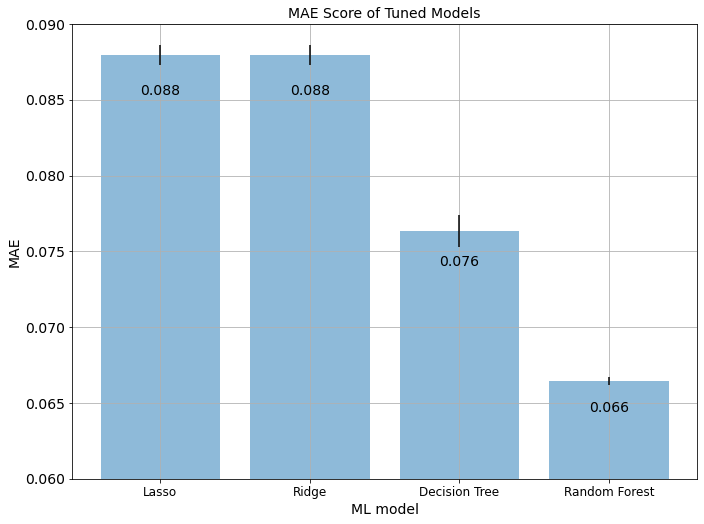

In [38]:
fig, ax = plt.subplots()
ax.bar(x_pos, meanl, yerr=stdl, align='center', alpha=0.5)
addlabels(models, meanl)
ax.set_ylabel('MAE')
ax.set_ylim([0.06, 0.09])
ax.set_xlabel('ML model')
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
ax.set_title('MAE Score of Tuned Models')
plt.tight_layout()
plt.show()
fig.savefig('figures/Model Comparison.jpg', dpi = 300)